<a href="https://colab.research.google.com/github/tasnimislam/TeamMeena/blob/main/Training_on_our_proposed_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset collection
The dataset used is collected from physionet naemly "The Term-Preterm EHG Database (TPEHG DB)" version 1.0.1
https://archive.physionet.org/physiobank/database/tpehgdb/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import and installation

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.ndimage import filters

!pip install wfdb==0.1.2
import wfdb
from wfdb import rdsamp
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import random
import pandas as pd
from glob import glob

! pip install emd
! pip install EMD-signal
! pip install flvlib
import emd
import pywt
import warnings
warnings.filterwarnings("ignore")

from PyEMD import EMD
from PyEMD import EEMD


from __future__ import division

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Flatten, SeparableConv1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, multiply, AveragePooling1D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
 
from keras.models import Model
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import *
from keras.utils import plot_model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import *


In [ ]:
def build_model():
    input_sig = Input(shape =(35360, 1), name='SignalInput')  #None,35360,1
    x = Conv1D (64, 10, activation='relu', padding='same', name='Conv1_1')(input_sig)
    x = Conv1D(64, 10, activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling1D(2, name='pool1')(x)
    
    x = Conv1D(64, 10, activation='relu', padding='same', name='Conv2_1')(x)
    x = Conv1D(64, 10, activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    x = Conv1D(128, 10, activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(4, name='pool3', data_format='channels_first')(x)
    x = Conv1D(128, 10, activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(4, name='pool4')(x)
    
    # x = Conv1D(64, 3, activation='relu', padding='same', name='Conv3_3')(x)
    # x = MaxPooling1D(2, name='pool5', data_format='channels_first')(x)
    x = GlobalAveragePooling1D(name='GAP')(x)
  
    
    #x = Flatten(name='flatten')(x)
    x = Dense(128, activation=LeakyReLU(alpha=0.1), name='fc1')(x)
    #x = Dropout(0.35, name='dropout1')(x)
    x = Dense(32, name='fc2')(x)
    #x = Dropout(0.2, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)
    
    model = Model(inputs=input_sig, outputs=x)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SignalInput (InputLayer)     [(None, 35360, 1)]        0         
_________________________________________________________________
Conv1_1 (Conv1D)             (None, 35360, 64)         704       
_________________________________________________________________
Conv1_2 (Conv1D)             (None, 35360, 64)         41024     
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 17680, 64)         0         
_________________________________________________________________
Conv2_1 (Conv1D)             (None, 17680, 64)         41024     
_________________________________________________________________
Conv2_2 (Conv1D)             (None, 17680, 64)         41024     
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 8840, 64)          0     

## Make input data

In [ ]:
keras_input = pd.DataFrame()

In [ ]:
file = open("/content/drive/MyDrive/mmg_dataset_v2/fvl files/0_3 theke 3 hertz.txt")
i = 0
# Record   | Chann | Gestation | Rec. time |   Group   |   RMS   |  Fmed  | Fpeak  | Samp. en. | Premature | Early 
for line in file:
  if i<2:
    i+=1
    continue
  line = line.split("|")

  keras_input.at[i, "Record"] = line[0]
  keras_input.at[i, "Channel_no"] = line[1]
  keras_input.at[i, "Gestation"] = line[2]
  keras_input.at[i, "Record_time"] = line[3]
  keras_input.at[i, "RMS"] = line[5]
  keras_input.at[i, "Fmed"] = line[6]
  keras_input.at[i, "Fpeak"] = line[7]
  keras_input.at[i, "Samp. en."] = line[8]
  keras_input.at[i, "Premature"] = line[9]
  keras_input.at[i, "Early"] = line[10][:-1]
  i +=1
keras_input.head()

,Record,Channel_no,Gestation,Record_time,RMS,Fmed,Fpeak,Samp. en.,Premature,Early
2,tpehg1007,1,35.00,31.29,16.5069,0.3688,0.3324,0.5180,t,f
3,tpehg1007,2,35.00,31.29,16.9946,0.3688,0.3159,0.3810,t,f
4,tpehg1007,3,35.00,31.29,8.4198,0.3981,0.2938,0.5640,t,f
5,tpehg1021,1,38.57,22.29,14.4062,0.4170,0.3828,0.4460,f,t
6,tpehg1021,2,38.57,22.29,12.3715,0.4120,0.3136,0.4370,f,t


In [ ]:
keras_input["Channel_no"] = keras_input.Channel_no.astype("int64")

In [ ]:
print(len(keras_input))

900


In [ ]:
listi = list(keras_input.columns)

In [ ]:
dat_file = glob("/content/drive/MyDrive/mmg_dataset_v2/term-preterm-ehg-database-1.0.1.zip (Unzipped Files)/term-preterm-ehg-database-1.0.1/tpehgdb/*.dat")
hea_file = glob("/content/drive/MyDrive/mmg_dataset_v2/term-preterm-ehg-database-1.0.1.zip (Unzipped Files)/term-preterm-ehg-database-1.0.1/tpehgdb/*.hea")
print(len(dat_file))
print(len(hea_file))

300
300


In [ ]:
signals = []
classi_list = []
read_file_dir = "/content/drive/MyDrive/mmg_dataset_v2/term-preterm-ehg-database-1.0.1.zip (Unzipped Files)/term-preterm-ehg-database-1.0.1/tpehgdb"
for i in range(len(keras_input)):
  record_name = keras_input.iloc[i]["Record"]
  record_name = os.path.join(read_file_dir, record_name + ".hea")
  sig, fields = rdsamp(hea_file[0][:-4], sampfrom=0, sampto=[], channels=[], physical=1, stacksegments=1, pbdl=0, keepfiles=0)
  if keras_input.iloc[i]["Channel_no"] == 1.0: signal = sig[:,2] 
  if keras_input.iloc[i]["Channel_no"] == 2.0: signal = sig[:,6]
  if keras_input.iloc[i]["Channel_no"] == 3.0: signal = sig[:,10]
  if keras_input.iloc[i]["Premature"]== keras_input.iloc[0]["Premature"]: classi = 0
  if keras_input.iloc[i]["Premature"]==keras_input.iloc[3]["Premature"]: classi = 1
  signals.append(signal)
  classi_list.append(classi)
  #if i==10: break

In [ ]:
train_sig=np.asarray(signals)
train_sig.shape

(900, 35360)

In [ ]:
train_sig = np.reshape(train_sig, (900, -1, 1))
train_sig.shape

(900, 35360, 1)

In [ ]:
Y = np.reshape(np.array(classi_list),(900,1))
Y.shape

In [ ]:
from keras.callbacks import *

weight_saver = ModelCheckpoint('Run_1.h5', monitor='accuracy', 
                                save_best_only=True, save_weights_only=True)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)
hist = model.fit(x = train_sig , 
                          y = Y, 
                          batch_size = 16,
                          epochs = 100,
                          callbacks = [weight_saver , annealer],
                          validation_split = 0.2,
                          shuffle = True,
                          verbose = 1)


Epoch 1/100
45/45 [==============================] - 13s 129ms/step - loss: 0.5880 - accuracy: 0.8089 - val_loss: 0.6551 - val_accuracy: 0.8833
Epoch 2/100
45/45 [==============================] - 5s 122ms/step - loss: 0.3978 - accuracy: 0.8708 - val_loss: 0.6441 - val_accuracy: 0.8833
Epoch 3/100
45/45 [==============================] - 5s 122ms/step - loss: 0.4190 - accuracy: 0.8581 - val_loss: 0.6397 - val_accuracy: 0.8833
Epoch 4/100
45/45 [==============================] - 5s 122ms/step - loss: 0.4327 - accuracy: 0.8501 - val_loss: 0.6392 - val_accuracy: 0.8833
Epoch 5/100
45/45 [==============================] - 5s 122ms/step - loss: 0.4227 - accuracy: 0.8505 - val_loss: 0.6365 - val_accuracy: 0.8833
Epoch 6/100
45/45 [==============================] - 5s 122ms/step - loss: 0.3597 - accuracy: 0.8870 - val_loss: 0.6307 - val_accuracy: 0.8833
Epoch 7/100
45/45 [==============================] - 5s 122ms/step - loss: 0.3913 - accuracy: 0.8678 - val_loss: 0.6197 - val_accuracy: 0.883

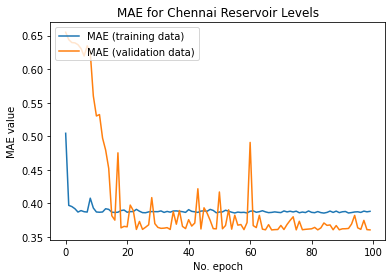

In [ ]:
# Plot history: MAE
plt.plot(hist.history['loss'], label='MAE (training data)')
plt.plot(hist.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

class_label:[0], prediction_name: Preterm


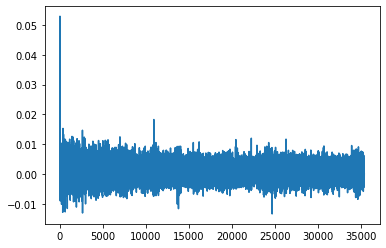

In [ ]:
plt.plot(train_sig[0])
print("class_label:{}, prediction_name: Preterm".format(Y[0]))